# CNN Multi Output guitar C Chord

- それぞれの弦について音色が良いかどうかを判定したい
- 参考：https://www.acceluniverse.com/blog/developers/2020/03/pythonefficientnet-multi-outpu.html

# ライブラリのインポート

In [2]:
import os
import time as ti
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn import model_selection
from sklearn import preprocessing

import librosa
import librosa.display

import tensorflow
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

import IPython.display as ipd

# データセットのパスを指定

In [3]:
base_dir = "C:/Users/shuhei/anaconda3/envs/hololens/workspace/"
dataset_dir = os.path.join(base_dir, "dataset/")
asses_dir_list = ["good/", "normal/", "bad/"]
guitar_dataset_dir = os.path.join("./../", "dataset_cv/")

# 各種関数の定義

In [4]:
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path)
    return x, fs

def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_sftf = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_sftf, n_mels=128)
    return melsp

def show_wave(x):
    plt.plot(x)
    plt.show()

def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs, y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(y=x, rate=rate)
    if len(x) > input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

def change_volume(x, rate=1.0):
    return x * rate

def save_np_data(filename, x, y, aug=None, rates=None):
    np_data = np.zeros(freq*time*len(x)).reshape(len(x), freq, time)
    np_targets = np.zeros(len(y))
    for i in range(len(y)):
        _x, fs = load_wave_data(dataset_dir, x[i])
        if aug is not None:
            _x = aug(x=_x, rate=rates[i])
        _x = calculate_melsp(_x)
        np_data[i] = _x
        np_targets[i] = y[i]
    np.savez(filename, x=np_data, y=np_targets)

# メルスペクトログラムの次元を定義

In [5]:
freq = 128
time = 517

# 訓練データ，テストデータを作成

In [6]:
x = []
y = []
for i in range(0, 3):
    for n in range(0, 100):
        file_num = str(n).zfill(3) + ".wav"
        filename = os.path.join(asses_dir_list[i], file_num)
        x.append(filename)
        y.append(i)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2, stratify=y)
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(len(x_train),
                                                                len(y_train), 
                                                                len(x_test), 
                                                                len(y_test)))

x train:240
y train:240
x test:60
y test:60


## データセットからnpzファイルを作成 

In [7]:
# test data
path = os.path.join(guitar_dataset_dir, "gar_melsp_test.npz")
if not os.path.exists(path):
    save_np_data(path, x_test, y_test)

# train data
path = os.path.join(guitar_dataset_dir, "gar_melsp_train_raw.npz")
if not os.path.exists(path):
    save_np_data(path, x_train,  y_train)

path = os.path.join(guitar_dataset_dir, "gar_melsp_train_wn.npz")
if not os.path.exists(path):
    rates = np.random.randint(1,50,len(x_train))/10000
    save_np_data(path, x_train,  y_train, aug=add_white_noise, rates=rates)

path = os.path.join(guitar_dataset_dir, "gar_melsp_train_ss.npz")
if not os.path.exists(path):
    rates = np.random.choice(np.arange(2,6),len(y_train))
    save_np_data(path, x_train,  y_train, aug=shift_sound, rates=rates)

path = os.path.join(guitar_dataset_dir, "gar_melsp_train_st.npz")
if not os.path.exists(path):
    rates = np.random.choice(np.arange(80,120),len(y_train))/100
    save_np_data(path, x_train,  y_train, aug=stretch_sound, rates=rates)

path = os.path.join(guitar_dataset_dir, "gar_melsp_train_cv.npz")
if not os.path.exists(path):
    rates = np.random.choice(np.arange(30,200),len(y_train))/100
    save_np_data(path, x_train,  y_train, aug=change_volume, rates=rates)

path = os.path.join(guitar_dataset_dir, "gar_melsp_train_co.npz")
if not os.path.exists(path):
    np_data = np.zeros(freq*time*len(x_train)).reshape(len(x_train), freq, time)
    np_targets = np.zeros(len(y_train))
    for i in range(len(y_train)):
        x, fs = load_wave_data(dataset_dir, x_train[i])
        x = add_white_noise(x=x, rate=np.random.randint(1,50)/1000)
        x = change_volume(x=x, rate=np.random.randint(30,200)/100)
        if np.random.choice((True,False)):
            x = shift_sound(x=x, rate=np.random.choice(np.arange(2,6)))
        else:
            x = stretch_sound(x=x, rate=np.random.choice(np.arange(80,120))/100)
        x = calculate_melsp(x)
        np_data[i] = x
        np_targets[i] = y_train[i]
    np.savez(path, x=np_data, y=np_targets)

## 訓練データとテストデータのファイル名を定義 

In [8]:
_train_files = ["gar_melsp_train_raw.npz", 
               "gar_melsp_train_ss.npz",
               "gar_melsp_train_st.npz", 
               "gar_melsp_train_wn.npz",
               "gar_melsp_train_cv.npz",
               "gar_melsp_train_co.npz"]
_test_file = "gar_melsp_test.npz"

train_files = [os.path.join(guitar_dataset_dir, path) for path in _train_files]
test_file = os.path.join(guitar_dataset_dir, _test_file)

## 訓練データとテストデータの数を定義 

In [9]:
train_num = 240
test_num = 60

## 訓練データとテストデータをロード 

In [10]:
x_train = np.zeros(freq*time*train_num*len(train_files)).reshape(train_num*len(train_files), freq, time)
y_train = np.zeros(train_num*len(train_files))

# 訓練データのロード
for i in range(len(train_files)):
    data = np.load(train_files[i])
    x_train[i*train_num:(i+1)*train_num] = data["x"]
    y_train[i*train_num:(i+1)*train_num] = data["y"]
    
# テストデータのロード
test_data = np.load(test_file)
x_test = test_data["x"]
y_test = test_data["y"]

y_train_inverse = np.abs(2 - y_train)
y_test_inverse = np.abs(2 - y_test)

# yを0, 1, 2の質的変数からワンホットベクトルに変換
classes = 3
y_train = keras.utils.to_categorical(y_train, classes)
y_train_inverse = keras.utils.to_categorical(y_train_inverse, classes)
y_test = keras.utils.to_categorical(y_test, classes)
y_test_inverse = keras.utils.to_categorical(y_test_inverse, classes)

x_train = x_train.reshape(train_num*6, freq, time, 1)
x_test = x_test.reshape(test_num, freq, time, 1)

print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(x_train.shape,
                                                                y_train.shape, 
                                                                x_test.shape, 
                                                                y_test.shape))

x train:(1440, 128, 517, 1)
y train:(1440, 3)
x test:(60, 128, 517, 1)
y test:(60, 3)


## モデルの作成 

In [11]:
def cba(inputs, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

inputs = Input(shape=(x_train.shape[1:]))

x_1 = cba(inputs, filters=32, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=32, kernel_size=(8,1), strides=(2,1))
x_1 = cba(x_1, filters=64, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=64, kernel_size=(8,1), strides=(2,1))

x_2 = cba(inputs, filters=32, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=32, kernel_size=(16,1), strides=(2,1))
x_2 = cba(x_2, filters=64, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=64, kernel_size=(16,1), strides=(2,1))

x_3 = cba(inputs, filters=32, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=32, kernel_size=(32,1), strides=(2,1))
x_3 = cba(x_3, filters=64, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=64, kernel_size=(32,1), strides=(2,1))

x_4 = cba(inputs, filters=32, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=32, kernel_size=(64,1), strides=(2,1))
x_4 = cba(x_4, filters=64, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=64, kernel_size=(64,1), strides=(2,1))

x = Add()([x_1, x_2, x_3, x_4])

x = cba(x, filters=128, kernel_size=(1,16), strides=(1,2))
x = cba(x, filters=128, kernel_size=(16,1), strides=(2,1))

_ = cba(x, filters=128, kernel_size=(1,8), strides=(1,2))
output_1 = cba(_, filters=128, kernel_size=(1,8), strides=(1,2))
output_1 = GlobalAveragePooling2D()(output_1)
output_1 = Dense(units=classes, activation='softmax', name='output_1')(output_1)

_ = cba(x, filters=128, kernel_size=(1,8), strides=(1,2))
output_2 = cba(_, filters=128, kernel_size=(1,8), strides=(1,2))
output_2 = GlobalAveragePooling2D()(output_2)
output_2 = Dense(units=classes, activation='softmax', name='output_2')(output_2)

model = Model(inputs=inputs, outputs=[output_1, output_2])

opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6, amsgrad=True)

model.compile(optimizer=opt, 
              loss={'output_1': 'categorical_crossentropy', 'output_2': 'categorical_crossentropy'},
              metrics={'output_1': 'accuracy', 'output_2': 'accuracy'})

## モデルの可視化 

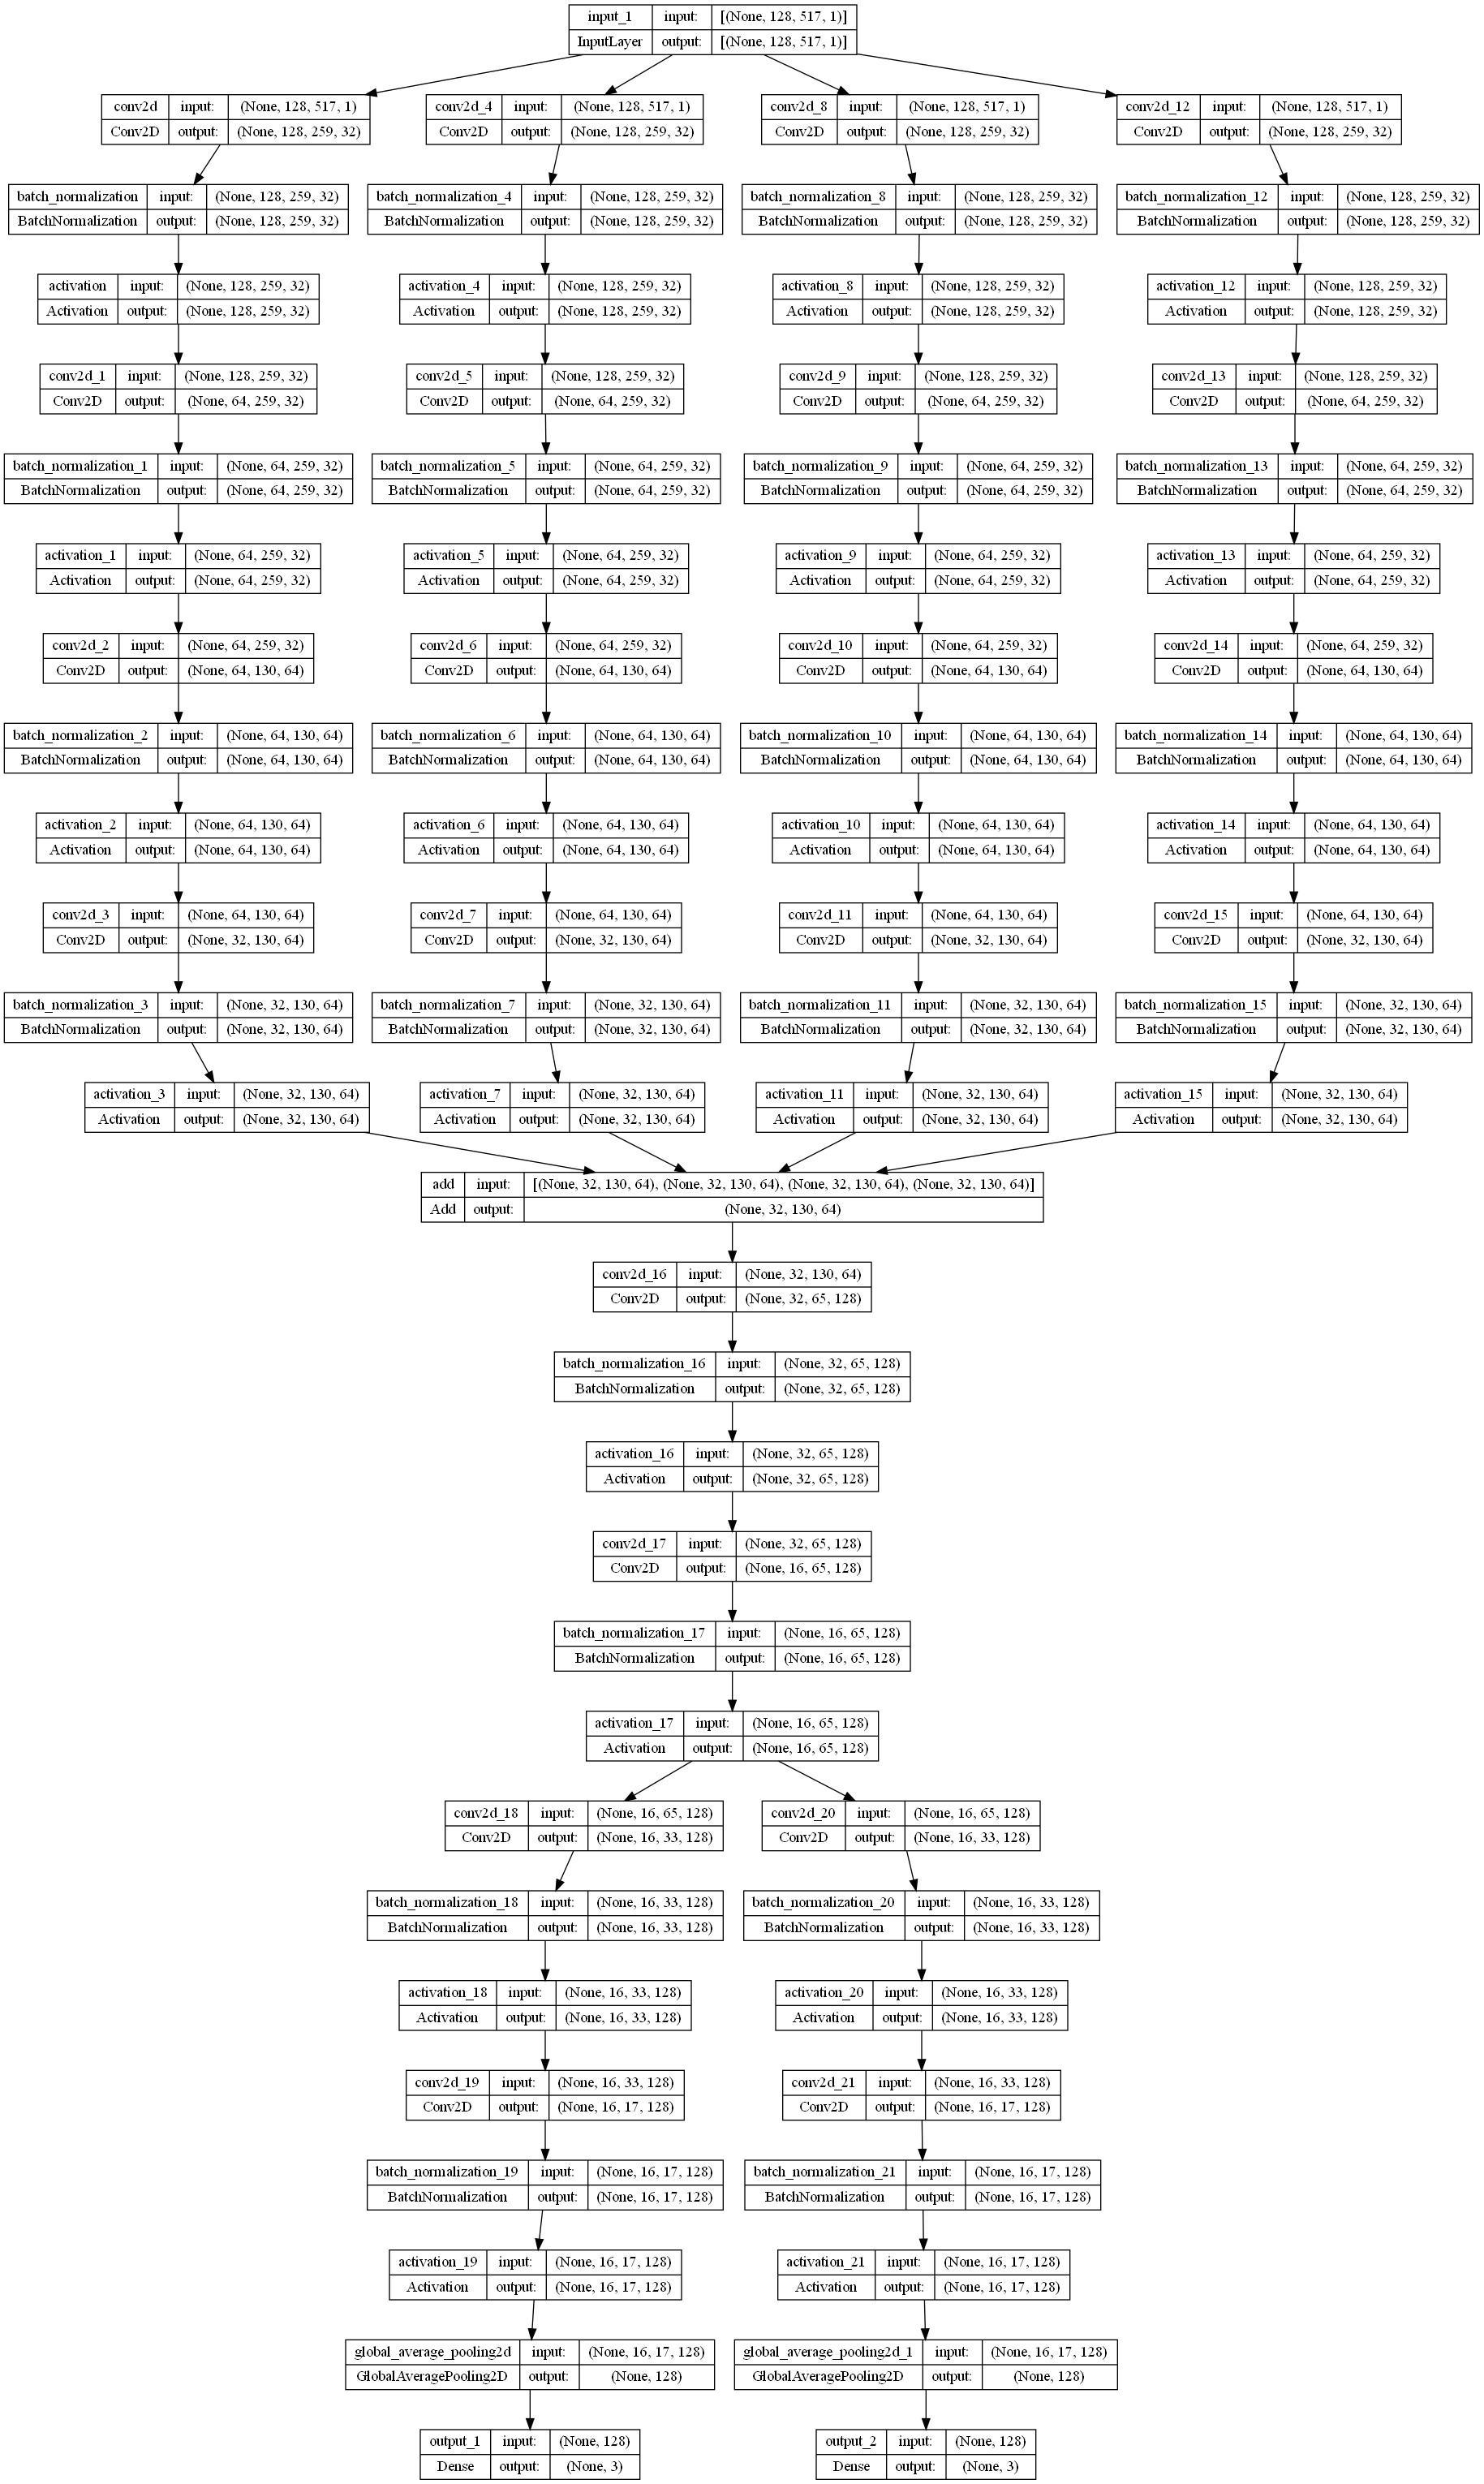

In [12]:
plot_model(
    model,
    show_shapes=True,
)

## モデルの保存場所を定義

In [13]:
model_dir = "./../models_cv"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

## 学習のオプションを設定

In [16]:
es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
chkpt = os.path.join(model_dir, 'esc50_.{epoch:02d}_{val_loss:.4f}_{output_1_accuracy:.4f}_{output_2_accuracy:.4f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

## モデルの学習 

In [17]:
batch_size = 16
epochs = 10

start_time = ti.time()
with tensorflow.device('/GPU:0'):
    
    model.fit(x_train, 
              {'output_1': y_train, 'output_2': y_train_inverse},
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, {'output_1': y_test, 'output_2': y_test_inverse}),
              verbose=1,
              callbacks=[es_cb, cp_cb])

    
end_time = ti.time()
print("time:", end_time - start_time)

Epoch 1/10
90/90 [==============================] - ETA: 0s - loss: 0.4123 - output_1_loss: 0.2049 - output_2_loss: 0.2074 - output_1_accuracy: 0.9236 - output_2_accuracy: 0.9187
Epoch 1: val_loss improved from inf to 3.85139, saving model to ./../models_cv\esc50_.01_3.8514_0.9236_0.9187.hdf5
90/90 [==============================] - 30s 333ms/step - loss: 0.4123 - output_1_loss: 0.2049 - output_2_loss: 0.2074 - output_1_accuracy: 0.9236 - output_2_accuracy: 0.9187 - val_loss: 3.8514 - val_output_1_loss: 2.0574 - val_output_2_loss: 1.7939 - val_output_1_accuracy: 0.6500 - val_output_2_accuracy: 0.6500
Epoch 2/10
90/90 [==============================] - ETA: 0s - loss: 0.3465 - output_1_loss: 0.1729 - output_2_loss: 0.1736 - output_1_accuracy: 0.9375 - output_2_accuracy: 0.9382
Epoch 2: val_loss did not improve from 3.85139
90/90 [==============================] - 30s 336ms/step - loss: 0.3465 - output_1_loss: 0.1729 - output_2_loss: 0.1736 - output_1_accuracy: 0.9375 - output_2_accuracy

In [18]:
model = load_model("./../models_cv/esc50_.05_0.0273_0.9778_0.9764.hdf5")

In [19]:
evaluation = model.evaluate(x_test, {'output_1': y_test, 'output_2': y_test_inverse})
print(evaluation)

2/2 [==============================] - 3s 988ms/step - loss: 0.0273 - output_1_loss: 0.0138 - output_2_loss: 0.0136 - output_1_accuracy: 1.0000 - output_2_accuracy: 1.0000
[0.02733655646443367, 0.013750811107456684, 0.013585745356976986, 1.0, 1.0]


good/050.wav
wave size:(66150,)
melsp size:(128, 517)
sampling rate:22050


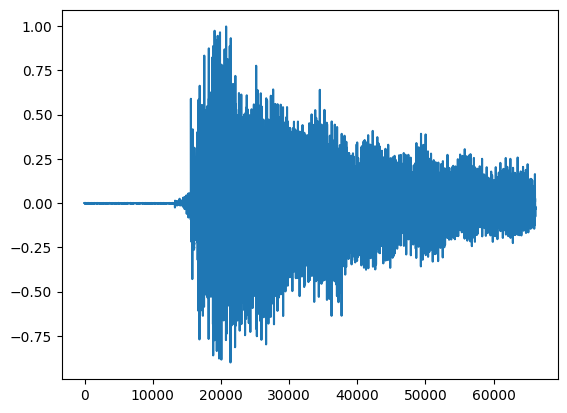

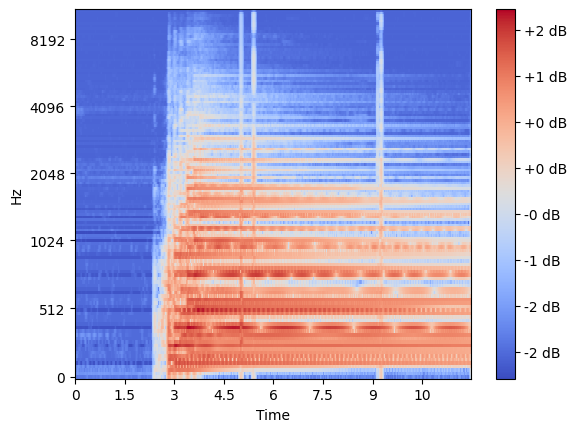

In [33]:
file_num = str(50).zfill(3) + ".wav"
file_name = os.path.join(asses_dir_list[0], file_num)
print(file_name)
x, fs = load_wave_data(dataset_dir, file_name)
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsampling rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)

In [34]:
ipd.Audio(x, rate=fs)

In [35]:
pred = model.predict(melsp.reshape(1, 128, 517, 1))

1/1 [==============================] - 0s 18ms/step


In [42]:
pred

[array([[9.3939400e-01, 6.0601931e-02, 4.0740897e-06]], dtype=float32),
 array([[4.4970038e-06, 5.4628108e-02, 9.4536740e-01]], dtype=float32)]

In [37]:
pred_label_1 = np.argmax(pred[0])
pred_label_2 = np.argmax(pred[1])

In [38]:
print(f"predicted output 1: {pred_label_1}\npredicted output 2: {pred_label_2}")

predicted output 1: 0
predicted output 2: 2
